In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

df = pd.read_excel('filtered-ref-converted.xlsx')

bins = [27.5, 31.5, 33.5, 38]
labels = ['low', 'mid', 'high']

df['bmi_group'] = pd.cut(df['孕妇BMI'], bins=bins, labels=labels, right=True)

# 查看每个区间的数量
print(df['bmi_group'].value_counts())

# 获取各分组的数据
df_low = df[df['bmi_group'] == 'low'].copy()
df_mid = df[df['bmi_group'] == 'mid'].copy()
df_high = df[df['bmi_group'] == 'high'].copy()
df_low['孕妇BMI'].head()


def compute_y_error(df, conc_col='Y染色体浓度', n_col='唯一比对的读段数  ', alpha=0.2):
    """
    计算 Y 染色体浓度标准误差和置信区间

    参数
    ----
    df : pd.DataFrame
        输入数据
    conc_col : str
        Y 染色体浓度列名
    n_col : str
        测序总片段数列名
    alpha : float
        显著性水平, 0.05 -> 95% CI, 0.10 -> 90% CI, 0.20 -> 80% CI

    返回
    ----
    df : pd.DataFrame
        增加 'SE_Y', 'CI_lower', 'CI_upper' 列
    """
    # z 值
    z = norm.ppf(1 - alpha/2)

    p = df[conc_col]
    N = df[n_col]

    # 避免 N=0 或 p 缺失
    se = np.sqrt(p*(1-p)/N)
    se[N <= 0] = np.nan
    se[p.isna()] = np.nan

    df['SE_Y'] = se
    df['CI_lower'] = (p - z*se).clip(0,1)
    df['CI_upper'] = (p + z*se).clip(0,1)

    return df

# 示例调用
df_trans = compute_y_error(df)
print(df_trans.head())

bmi_group
low     407
mid     227
high    214
Name: count, dtype: int64
   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
2   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
3   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   
4   6  A002  32  149.0  76.0  2023-11-09 00:00:00  自然受孕  20240310       2   

          孕周  ...  21号染色体的GC含量  被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  \
0  11.857143  ...     0.399399    0.027484       NaN     1     0       是   
1  20.142857  ...     0.399480    0.022312       NaN     1     0       是   
2  22.857143  ...     0.397212    0.023280       NaN     1     0       是   
3  13.857143  ...     0.404868    0.024212       NaN     2     1       否   
4  16.714286  ...     0.399467    0.026017       NaN     2     1       否   

   bmi_g

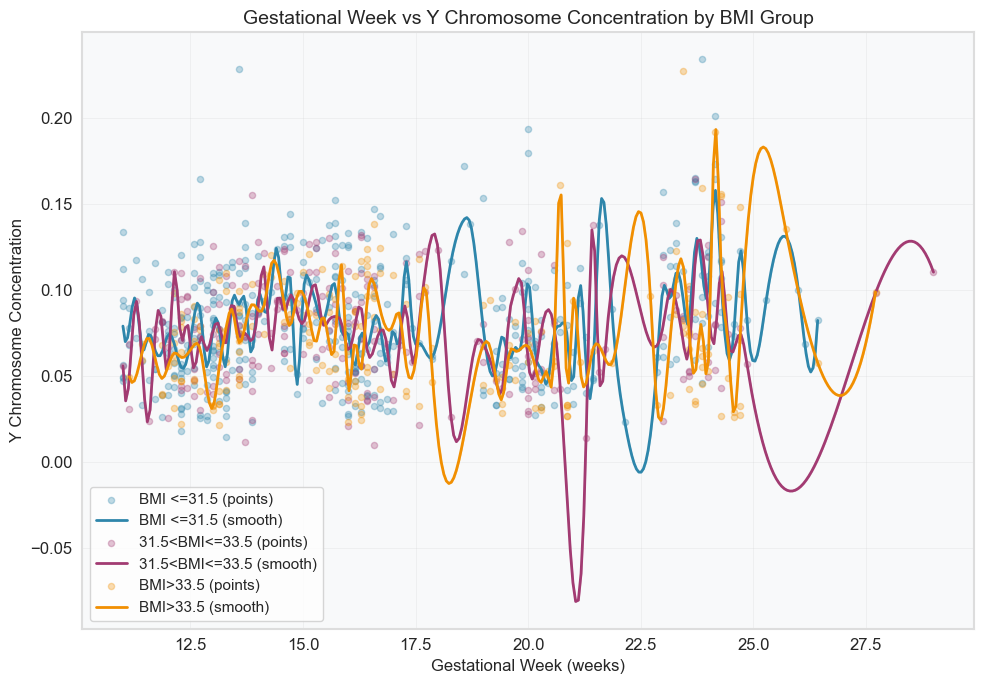

In [2]:
import seaborn as sns
from scipy.interpolate import make_interp_spline

# 设置样式
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.size'] = 12

# BMI 分组
bins = [27.5, 31.5, 33.5, 37.75]
labels = ['BMI <=31.5', '31.5<BMI<=33.5', 'BMI>33.5']
df['BMI_group'] = pd.cut(df['孕妇BMI'], bins=bins, labels=labels, include_lowest=True)

# 创建画布
fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#2E86AB', '#A23B72', '#F18F01']

for i, grp in enumerate(labels):
    sub = df[df['BMI_group']==grp]
    if sub.empty:
        continue
    
    # 按孕周取平均
    agg = sub.groupby('孕周').agg({'Y染色体浓度':'mean', 'SE_Y':'mean'}).reset_index()
    weeks = agg['孕周'].values
    yvals = agg['Y染色体浓度'].values
    sevals = agg['SE_Y'].values
    
    # 散点（原始数据）
    ax.scatter(sub['孕周'], sub['Y染色体浓度'], alpha=0.3, s=20, color=colors[i], label=f"{grp} (points)")
    
    if len(weeks) >= 4:  # 样条至少4个点
        # 排序
        sort_idx = np.argsort(weeks)
        weeks = weeks[sort_idx]
        yvals = yvals[sort_idx]
        sevals = sevals[sort_idx]

        # 样条平滑
        xnew = np.linspace(weeks.min(), weeks.max(), 300)
        spline = make_interp_spline(weeks, yvals, k=3)
        y_smooth = spline(xnew)
        
        se_spline = make_interp_spline(weeks, sevals, k=3)
        se_smooth = se_spline(xnew)
        
        # 平滑曲线
        ax.plot(xnew, y_smooth, color=colors[i], linewidth=2, label=f"{grp} (smooth)")
        # 误差带 ±SE
        ax.fill_between(xnew, y_smooth - se_smooth, y_smooth + se_smooth, color=colors[i], alpha=0.2)

        
# 设置网格和样式
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('#F8F9FA')

# 美化边框
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#DDDDDD')        
        
# 标签与标题
ax.set_xlabel("Gestational Week (weeks)", fontsize=12)
ax.set_ylabel("Y Chromosome Concentration", fontsize=12)
ax.set_title("Gestational Week vs Y Chromosome Concentration by BMI Group", fontsize=14)
ax.legend(loc="best", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

import matplotlib.pyplot as plt
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置支持中文的字体，优先使用SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
sns.set_theme(style="white", font_scale=1.2)

df = pd.read_excel('filtered-ref-converted.xlsx')

bins = [27.5, 38]
labels = ['mid']
df['bmi_group'] = pd.cut(df['孕妇BMI'], bins=bins, labels=labels, right=True)

# 查看每个区间的数量
print(df['bmi_group'].value_counts())

# 获取各分组的数据

df_mid = df[df['bmi_group'] == 'mid'].copy()

compute_y_error(df_mid, conc_col='Y染色体浓度', n_col='唯一比对的读段数  ', alpha=0.2)
df_mid['Y_flag'] = (df['Y染色体浓度'] >= 0.04).astype(int)

print (len(df_mid))
df_mid.head()

bmi_group
mid    848
Name: count, dtype: int64
848


,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,孕周,...,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康,bmi_group,SE_Y,CI_lower,CI_upper,Y_flag
0,1,A001,31,160.0,72.0,2023-02-01 00:00:00,自然受孕,20230429,1,11.857143,...,0.027484,NaN,1,0,是,mid,0.000081,0.025832,0.026040,0
1,3,A001,31,160.0,73.0,2023-02-01 00:00:00,自然受孕,20230625,3,20.142857,...,0.022312,NaN,1,0,是,mid,0.000145,0.065985,0.066357,1
2,4,A001,31,160.0,74.0,2023-02-01 00:00:00,自然受孕,20230716,4,22.857143,...,0.023280,NaN,1,0,是,mid,0.000113,0.061047,0.061336,1
3,5,A002,32,149.0,74.0,2023-11-09 00:00:00,自然受孕,20240219,1,13.857143,...,0.024212,NaN,2,1,否,mid,0.000133,0.059060,0.059400,1
4,6,A002,32,149.0,76.0,2023-11-09 00:00:00,自然受孕,20240310,2,16.714286,...,0.026017,NaN,2,1,否,mid,0.000103,0.042269,0.042534,1


In [4]:
from copulas.multivariate import GaussianMultivariate
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
# 如果 Y_flag 列不存在，可以用以下方法生成：


# 选择变量
cols = ['身高', '体重', '年龄', 'SE_Y', 'Y染色体浓度', '孕妇BMI', '孕周']
df_copula = df_mid[cols].copy()

# 归一化到 [0,1] 方便 Copula
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_copula), columns=cols)


# -------------------------------
# 3️⃣ 拟合 Gaussian Copula
# -------------------------------
copula = GaussianMultivariate()
copula.fit(df_scaled)

# -------------------------------
# 4️⃣ 生成模拟样本
# -------------------------------
n_samples = 1000
samples = copula.sample(n_samples)

# 将样本反归一化回原始尺度
samples_orig = pd.DataFrame(scaler.inverse_transform(samples), columns=cols)

# 查看样本分布
print(samples_orig.describe())
print (type(samples_orig ))
samples_orig.head()

                身高           体重           年龄         SE_Y       Y染色体浓度  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    161.246142    83.254258    28.847696     0.000136     0.077194   
std       5.526948     8.778182     3.793026     0.000032     0.034840   
min     142.535217    59.890327    19.550563     0.000042     0.000133   
25%     157.500622    76.923886    26.439684     0.000113     0.050384   
50%     161.338142    82.657528    28.650510     0.000137     0.074115   
75%     165.333359    88.280360    30.960534     0.000159     0.100377   
max     176.924505   111.540553    43.182804     0.000237     0.233478   

             孕妇BMI           孕周  
count  1000.000000  1000.000000  
mean     31.956924    16.848039  
std       2.374743     4.245421  
min      27.126565     9.238997  
25%      30.145803    13.498763  
50%      31.527982    15.755543  
75%      33.588554    20.263428  
max      38.450067    30.006942  
<class 'pandas.core.frame.D

,身高,体重,年龄,SE_Y,Y染色体浓度,孕妇BMI,孕周
0,166.392947,82.294427,34.576116,0.000079,0.024516,29.935046,13.108775
1,163.670040,95.087228,30.417905,0.000156,0.077444,35.005435,16.191375
2,158.887151,73.094068,28.970962,0.000092,0.032297,28.943756,13.451874
3,164.645180,82.503300,29.158777,0.000160,0.092655,30.774376,22.951790
4,158.139118,73.741995,25.085990,0.000182,0.144433,29.291778,15.403361


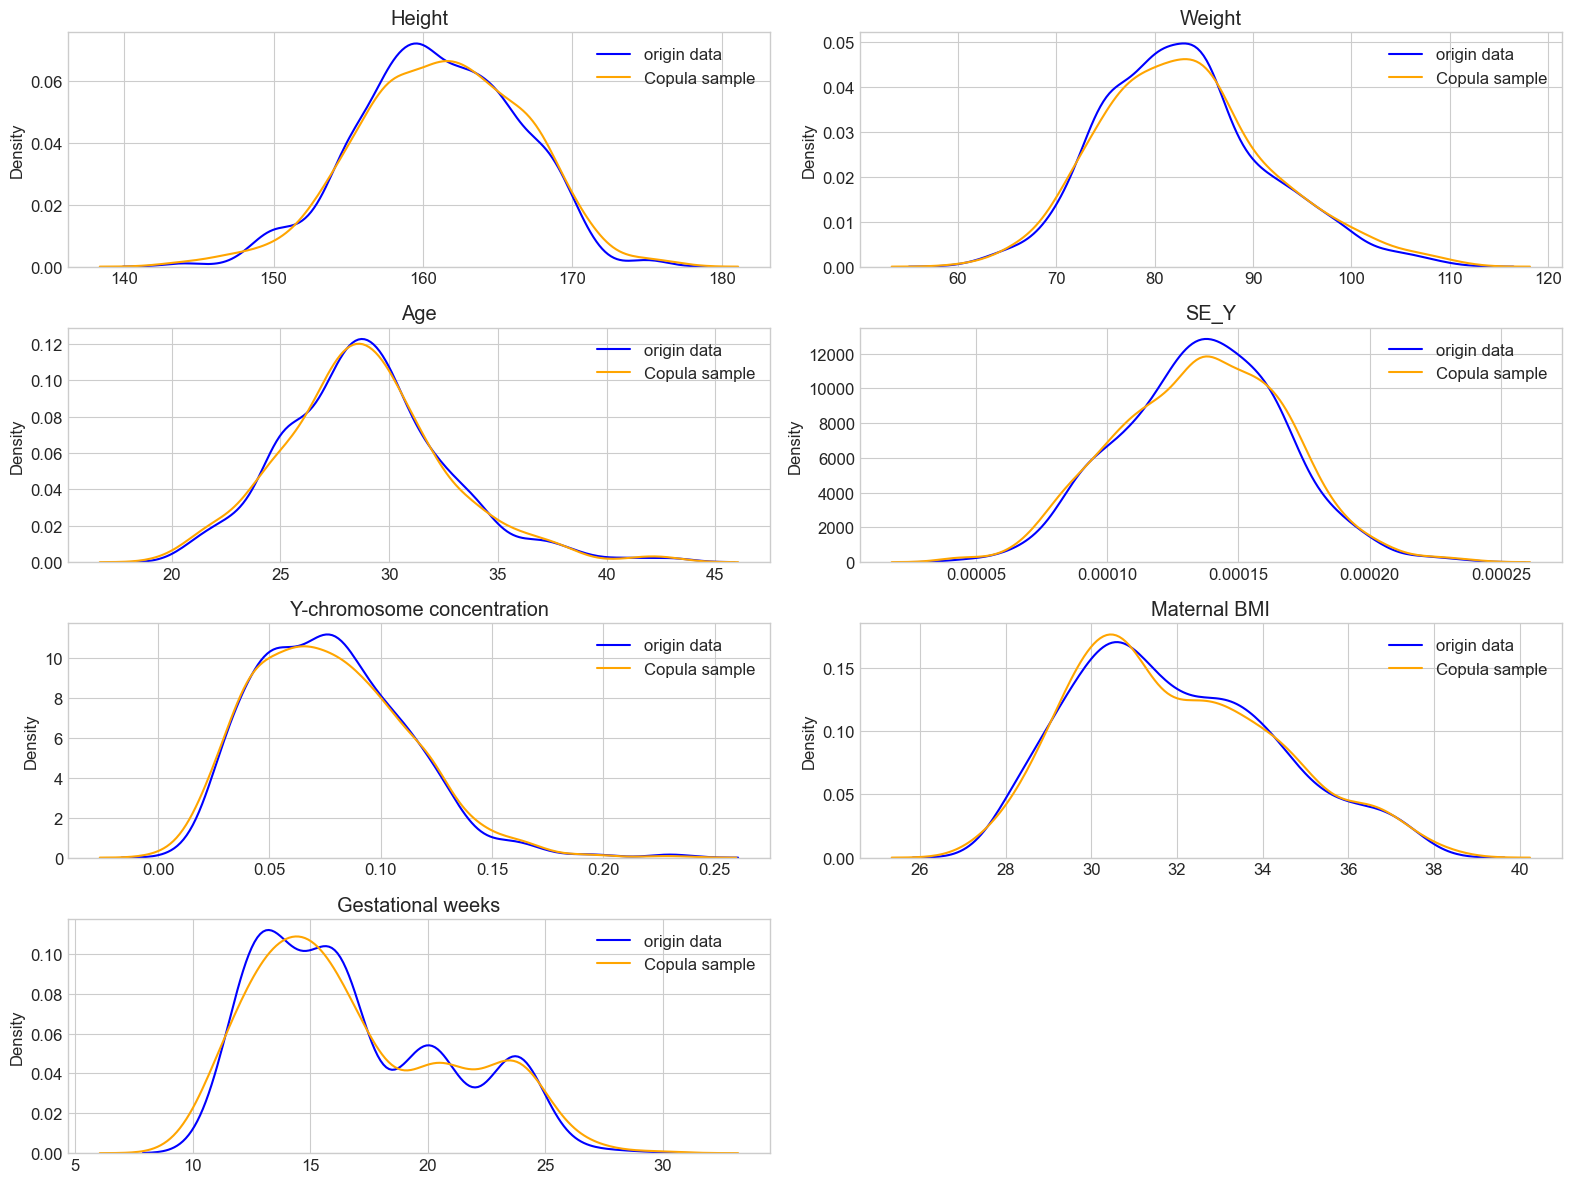

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 定义中文列名和对应的英文名映射
column_names_map = {
    '身高': 'Height',
    '体重': 'Weight',
    '年龄': 'Age',
    'Y染色体浓度': 'Y-chromosome concentration',
    '孕妇BMI': 'Maternal BMI',
    '孕周': 'Gestational weeks'
}

cols = ['身高','体重','年龄','SE_Y','Y染色体浓度','孕妇BMI','孕周']

# 计算行数和列数
n_cols_plot = 2  # 设置每行的列数
n_rows_plot = math.ceil(len(cols) / n_cols_plot) # 向上取整计算行数

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(8 * n_cols_plot, 3 * n_rows_plot))
# 展平 axes 数组，以便于循环迭代
axes = axes.flatten()

for i, col in enumerate(cols):
    english_col_name = column_names_map.get(col, col)

    sns.kdeplot(df_mid[col], ax=axes[i], label='origin data', color='blue')
    sns.kdeplot(samples_orig[col], ax=axes[i], label='Copula sample', color='orange')

    axes[i].set_title(english_col_name)
    axes[i].legend()
    axes[i].set_xlabel('')
    
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    plt.gca().set_facecolor('#F8F9FA')

    # 美化边框
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#DDDDDD') 

# 移除多余的子图（如果总图数不是n_rows_plot * n_cols_plot的整数倍）
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

# 设置网格和样式
   
    
plt.tight_layout()
plt.savefig("p3-vis.png",dpi=300, bbox_inches='tight')          # 矢量图，适合论文
plt.show()



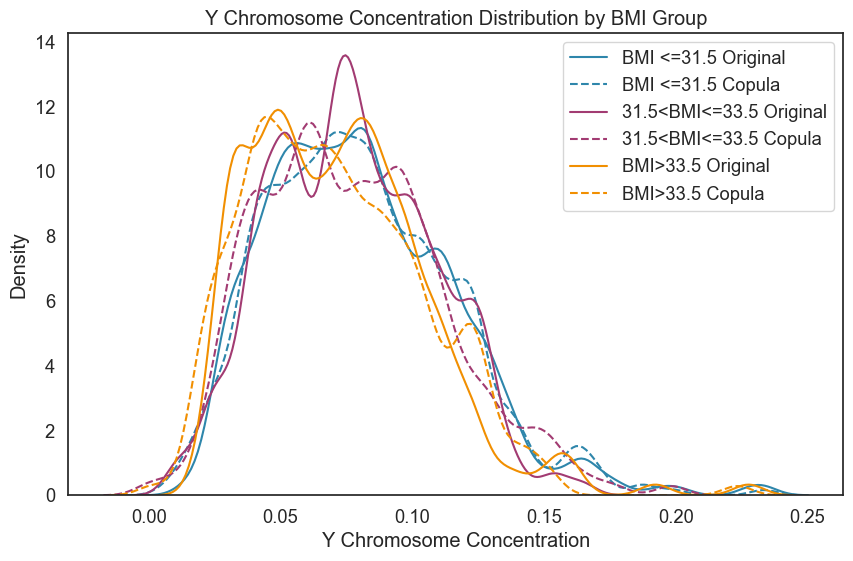

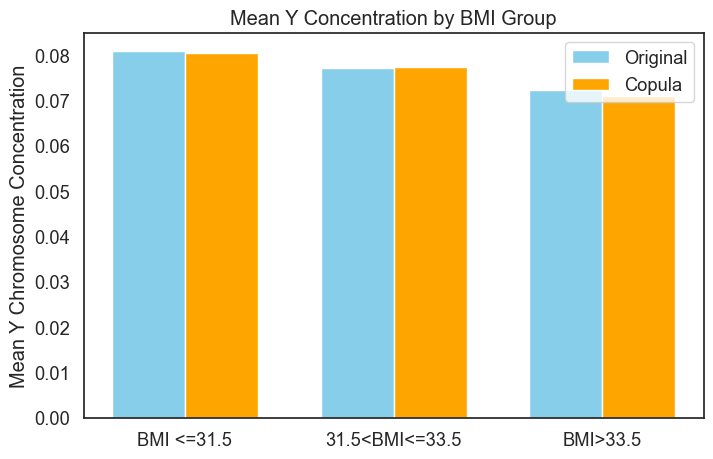

In [6]:
bins = [27.5, 31.5, 33.5, 38]
labels = ['BMI <=31.5', '31.5<BMI<=33.5', 'BMI>33.5']
df_mid['BMI_group'] = pd.cut(df_mid['孕妇BMI'], bins=bins, labels=labels, include_lowest=True)
samples_orig['BMI_group'] = pd.cut(samples_orig['孕妇BMI'], bins=bins, labels=labels, include_lowest=True)

# 绘制 KDE 曲线
fig, ax = plt.subplots(figsize=(10,6))
colors = ['#2E86AB', '#A23B72', '#F18F01']

for i, grp in enumerate(labels):
    # 原始数据
    orig_mask = df_mid['BMI_group'] == grp
    orig_vals = df_mid.loc[orig_mask, 'Y染色体浓度']
    
    # Copula 样本
    copula_mask = samples_orig['BMI_group'] == grp
    copula_vals = samples_orig.loc[copula_mask, 'Y染色体浓度']
    
    # KDE 曲线
    sns.kdeplot(orig_vals, bw_adjust=0.5, label=f"{grp} Original", color=colors[i], linestyle='-')
    sns.kdeplot(copula_vals, bw_adjust=0.5, label=f"{grp} Copula", color=colors[i], linestyle='--')

ax.set_xlabel("Y Chromosome Concentration")
ax.set_ylabel("Density")
ax.set_title("Y Chromosome Concentration Distribution by BMI Group")
ax.legend()
plt.show()

# 可选柱状图，展示各 BMI 分组的平均浓度
orig_mean = df_mid.groupby('BMI_group')['Y染色体浓度'].mean()
copula_mean = samples_orig.groupby('BMI_group')['Y染色体浓度'].mean()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, orig_mean, width, label='Original', color='skyblue')
ax.bar(x + width/2, copula_mean, width, label='Copula', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Mean Y Chromosome Concentration")
ax.set_title("Mean Y Concentration by BMI Group")
ax.legend()
plt.show()

In [7]:
from scipy.interpolate import PchipInterpolator
t_points = [10, 12, 24.5]
# 对应风险成本（可按中值或上界设定）
C_points = [0.02, 0.05, 0.40]  # 这里用小数表示 4%, 6%, 15%

# 构建 PCHIP 光滑插值
risk_cost = PchipInterpolator(t_points, C_points)

# 测试绘图
t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

In [8]:
def fit_samples_and_optimize(df_group, samples_orig, lam=0.5):
    """
    使用已生成的 Copula 样本 samples_orig 来计算效用函数 U，并找到最佳孕周。

    输入:
        df_group: DataFrame, 至少包含 ['孕妇BMI', '孕周', 'Y染色体浓度']
        samples_orig: Copula 生成的模拟样本，至少包含 ['孕妇BMI', '孕周', 'Y染色体浓度']
        lam: 风险权重 λ

    输出:
        best_t: 最优孕周
        U_values: 效用函数曲线 (list)
        probabilities: Y浓度>=0.04的概率曲线 (list)
        prob_pred: 每个样本的个体化预测概率 (array)
    """
    data = df_group[['孕妇BMI', '孕周', 'Y染色体浓度']].dropna()
    if len(data) < 30:
        print("数据不足，跳过")
        return None, None, None, None

    weeks = np.arange(10, 24.5, 0.25)
    U_values = []
    probabilities = []

    for t in weeks:
        bmi_mean = data['孕妇BMI'].mean()
        # 取 samples_orig 中孕周接近 t、BMI接近平均值的子集
        cond = samples_orig[
            (np.abs(samples_orig['孕周'] - t) <= 0.3) &
            (np.abs(samples_orig['孕妇BMI'] - bmi_mean) <= 1.0)
        ]

        prob = np.mean(cond['Y染色体浓度'] >= 0.04) if len(cond) > 0 else 0
        probabilities.append(prob)

        # 风险成本
        C = risk_cost(t)
        U = prob - lam * C
        U_values.append(U)

    # 找到 U 最大的孕周
    best_idx = int(np.argmax(U_values))
    best_t = weeks[best_idx]

    # 个体化预测
    prob_pred = []
    for _, row in data.iterrows():
        t = row['孕周']
        bmi = row['孕妇BMI']
        cond = samples_orig[
            (np.abs(samples_orig['孕周'] - t) <= 0.3) &
            (np.abs(samples_orig['孕妇BMI'] - bmi) <= 1.0)
        ]
        prob_pred.append(np.mean(cond['Y染色体浓度'] >= 0.04) if len(cond) > 0 else 0.0)

    prob_pred = np.array(prob_pred)

    return best_t, U_values, probabilities, prob_pred

In [9]:
best_t_low, U_low, prob_low, prob_pred_low = fit_samples_and_optimize(df_low, samples_orig, lam=0.5)
best_t_mid, U_mid, prob_mid, prob_pred_mid = fit_samples_and_optimize(df_mid, samples_orig, lam=0.5)
best_t_high, U_high, prob_high, prob_pred_high = fit_samples_and_optimize(df_high, samples_orig, lam=0.5)


ValueError: Shapes of x (74,) and y (58,) are incompatible

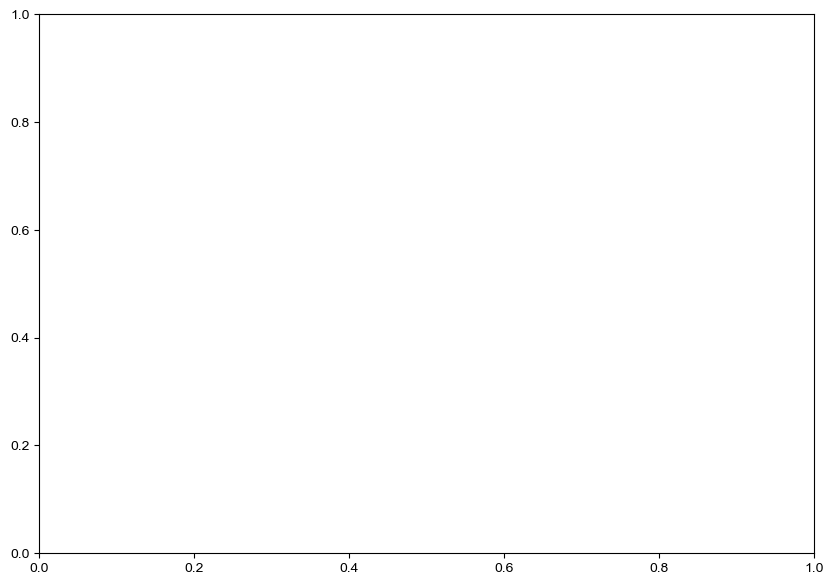

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
plt.style.use('default')
sns.set_palette("husl")
# -------------------------
# 概率曲线 vs 孕周（单y轴 + 样条平滑 + 趋势直线）
# -------------------------
fig, ax = plt.subplots(figsize=(10, 7))

plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
plt.rcParams['font.size'] = 12

# 平滑函数
def smooth_curve(x, y, num=300):
    x = np.array(x)
    y = np.array(y)
    if len(x) < 4:  # 样条至少要4个点
        return x, y
    x_new = np.linspace(x.min(), x.max(), num)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# 画曲线 + 趋势线的函数
def plot_curve_and_trend(x, y, color, label):
    if y is None:
        return
    # 平滑曲线
    x_new, y_smooth = smooth_curve(x, y)
    ax.plot(x_new, y_smooth, color=color, linewidth=2, label=label)

    # 直线拟合（一次多项式）
    coeffs = np.polyfit(x, y, 1)
    trend = np.poly1d(coeffs)
    ax.plot(x, trend(x), color=color, linestyle="--", linewidth=1.8,
            label=f"Trend - {label}")

# 绘制三条曲线及趋势线#2E86AB #A23B72 #F18F01
plot_curve_and_trend(weeks, prob_low, "#2E86AB", "BMI [27-31.5]")
plot_curve_and_trend(weeks, prob_mid, "#A23B72", "BMI [31.5-33.5]")
plot_curve_and_trend(weeks, prob_high, "#F18F01", "BMI [31.5-38]")

# plot_curve_and_trend(weeks, prob_low, label = "BMI [27-31.5]")
# plot_curve_and_trend(weeks, prob_mid, label="BMI [31.5-33.5]")
# plot_curve_and_trend(weeks, prob_high, label="BMI [31.5-38]")


# 标签与标题
ax.set_xlabel("Gestational Week (weeks)", fontsize=12)
ax.set_ylabel("P(Y concentration > 0.04)", fontsize=12)
ax.set_title("Smoothed Probability & Trend Lines (by BMI group)", fontsize=14)

ax.legend(loc="best", frameon=True, fontsize=11)
ax.grid(alpha=0.3)


# 设置网格和样式
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('#F8F9FA')

# 美化边框
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#DDDDDD')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import seaborn as sns

def plot_Y_prob_by_BMI(samples_orig, threshold=0.04, week_step=0.5):
    """
    绘制 BMI 分组下 Y 染色体浓度 ≥ threshold 的概率随孕周变化曲线
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,6))

    # BMI 分组
    bins = [27.5, 31.5, 33.5, 38]
    labels = ['BMI 27-31.5', 'BMI 31.5-33.5', 'BMI >33.5']
    samples_orig['BMI_group'] = pd.cut(samples_orig['孕妇BMI'], bins=bins, labels=labels, include_lowest=True)

    colors = ['#2E86AB', '#A23B72', '#F18F01']

    for i, grp in enumerate(labels):
        df_grp = samples_orig[samples_orig['BMI_group'] == grp].copy()
        if df_grp.empty:
            continue

        # 分箱计算每个 bin 的概率均值
        min_week = df_grp['孕周'].min()
        max_week = df_grp['孕周'].max()
        bins_week = np.arange(min_week, max_week + week_step, week_step)
        df_grp['week_bin'] = pd.cut(df_grp['孕周'], bins=bins_week, include_lowest=True)

        prob_by_bin = df_grp.groupby('week_bin')['Y染色体浓度'].apply(lambda x: np.mean(x >= threshold))
        bin_centers = [interval.mid for interval in prob_by_bin.index]

        # 过滤掉 NaN
        valid_idx = ~np.isnan(prob_by_bin.values)
        x = np.array(bin_centers)[valid_idx]
        y = np.array(prob_by_bin.values)[valid_idx]

        # 样条平滑
        if len(x) >= 4:  # 至少 4 个点
            x_new = np.linspace(x.min(), x.max(), 300)
            spline = make_interp_spline(x, y, k=3)
            y_smooth = spline(x_new)
            plt.plot(x_new, y_smooth, color=colors[i], linewidth=2, label=f'{grp} (smoothed)')
        else:
            plt.scatter(x, y, color=colors[i], label=f'{grp} (points)')

    plt.xlabel("Gestational Week")
    plt.ylabel(f"Probability of Y ≥ {threshold}")
    plt.title(f"Y Chromosome Concentration ≥ {threshold} by BMI Group")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    
plot_Y_prob_by_BMI(samples_orig, threshold=0.04, week_step=0.5)